### Importazione librerie

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import Metriche_di_performance as mdp

In [16]:
btc_ohlcv = pd.read_csv('Bitcoin futures (USDT) 25-03-2020-10-36-00_03-05-2025-00-00-00 timeframe 1m.csv')
btc_ohlcv.set_index('timestamp', inplace=True)
btc_ohlcv.index = pd.to_datetime(btc_ohlcv.index)
btc_ohlcv

,open,high,low,close,volume
timestamp,,,,,
2020-03-25 10:36:00,6500.0,6500.0,6500.0,6500.0,0.001
2020-03-25 10:37:00,6500.0,6500.0,6500.0,6500.0,0.000
2020-03-25 10:38:00,6500.0,6500.0,6500.0,6500.0,0.000
2020-03-25 10:39:00,6500.0,6500.0,6500.0,6500.0,0.000
2020-03-25 10:40:00,6500.0,6500.0,6500.0,6500.0,0.000
...,...,...,...,...,...
2025-05-02 23:56:00,96789.9,96796.9,96789.9,96796.9,9.169
2025-05-02 23:57:00,96796.9,96840.0,96796.9,96831.7,42.991
2025-05-02 23:58:00,96831.7,96833.5,96831.6,96833.5,11.743


In [17]:
btc_ohlcv = btc_ohlcv.iloc[:]
btc_ohlcv

,open,high,low,close,volume
timestamp,,,,,
2020-03-25 10:36:00,6500.0,6500.0,6500.0,6500.0,0.001
2020-03-25 10:37:00,6500.0,6500.0,6500.0,6500.0,0.000
2020-03-25 10:38:00,6500.0,6500.0,6500.0,6500.0,0.000
2020-03-25 10:39:00,6500.0,6500.0,6500.0,6500.0,0.000
2020-03-25 10:40:00,6500.0,6500.0,6500.0,6500.0,0.000
...,...,...,...,...,...
2025-05-02 23:56:00,96789.9,96796.9,96789.9,96796.9,9.169
2025-05-02 23:57:00,96796.9,96840.0,96796.9,96831.7,42.991
2025-05-02 23:58:00,96831.7,96833.5,96831.6,96833.5,11.743


### Simulazione

In [18]:
def simulate_value_averaging_modified(
    btc_ohlcv: pd.DataFrame,
    timeframe: int,
    aumento_obiettivo: float,
    tp: float,
    compra_pure: bool,
    initial_cash: float,
    obiettivo_percentuale: bool = False,
    acquisto_classico: bool = False
) -> pd.DataFrame:
    """
    Simula una strategia di "value averaging" modificato su dati OHLCV di Bitcoin.

    Parametri:
    - btc_ohlcv: DataFrame con indice datetime e almeno la colonna 'close'
    - timeframe: ogni quanti minuti applicare la strategia
    - aumento_obiettivo: incremento (in USDT o in percentuale della liquidità) dell'obiettivo per ogni periodo
    - tp: take profit in percentuale (es. 0.02 = 2%)
    - compra_pure: se True, compra con tutta la liquidità residua se non sufficiente per raggiungere l'obiettivo
    - initial_cash: liquidità iniziale in USDT
    - obiettivo_percentuale: se True, interpreta aumento_obiettivo come percentuale (0 <= aumento_obiettivo <= 1)
      della liquidità attuale da usare come base per l'incremento dell'obiettivo, altrimenti come valore di cui aumentare l'obiettivo
    - acquisto_classico: se True, utilizza la logica classica di value averaging (acquisto quando il valore
      attuale dei bitcoin posseduti è inferiore all'obiettivo); se False (default), l'acquisto avviene solo quando il 
      prezzo è inferiore al prezzo medio di acquisto (come nella versione modificata)

    Ritorna:
    DataFrame indicizzato per timestamp con colonne:
    ['prezzo', 'azione', 'valore_bitcoin', 'liquidità', 'portafoglio_totale']
    """
    # Validazione parametro obiettivo_percentuale
    if obiettivo_percentuale and not (0 <= aumento_obiettivo <= 1):
        raise ValueError("Quando obiettivo_percentuale è True, aumento_obiettivo deve essere tra 0 e 1")

    cash = initial_cash
    crypto = 0.0
    sum_spent = 0.0
    sum_btc = 0.0
    steps = 0
    base_increment = aumento_obiettivo if not obiettivo_percentuale else initial_cash * aumento_obiettivo
    records = []

    for timestamp, row in btc_ohlcv.iterrows():
        price = row['close']
        action = 'niente'
        steps += 1

        if steps % timeframe == 0:
            period = steps // timeframe
            # Calcolo dell'incremento obiettivo per questo ciclo (in base a obiettivo_percentuale)
            if obiettivo_percentuale and (sum_btc == 0 and period == 1 or action == 'vendita'):
                base_increment = cash * aumento_obiettivo
            objective = period * base_increment

            current_value = crypto * price
            avg_price = sum_spent / sum_btc if sum_btc > 0 else None

            # Vendita se prezzo >= avg_price * (1 + tp)
            if crypto > 0 and avg_price is not None and price >= avg_price * (1 + tp):
                proceeds = crypto * price
                cash += proceeds
                crypto = 0.0
                sum_spent = 0.0
                sum_btc = 0.0
                steps = 0  # reset ciclo dopo vendita
                action = 'vendita'

            else:
                # Calcolo della quantità necessaria per raggiungere l'obiettivo
                needed = objective - current_value
                
                # Determina la condizione di acquisto in base a acquisto_classico
                if acquisto_classico:
                    buy_condition = needed > 0
                else:
                    buy_condition = (avg_price is None or price < avg_price)

                if buy_condition and needed > 0:
                    if cash >= needed:
                        spend = needed
                        action = 'acquisto'
                    elif compra_pure and cash > 0:
                        spend = cash
                        action = 'acquisto'
                    else:
                        spend = 0.0
                        action = 'niente (tentato acquisto)'

                    if spend > 0:
                        amount = spend / price
                        crypto += amount
                        cash -= spend
                        sum_spent += spend
                        sum_btc += amount

        total = cash + crypto * price
        records.append({
            'timestamp': timestamp,
            'prezzo': price,
            'azione': action,
            'valore_bitcoin': crypto * price,
            'liquidità': cash,
            'portafoglio_totale': total
        })

    result = pd.DataFrame(records).set_index('timestamp')
    return result

In [19]:
def plot_equity_with_hold(sim_results: pd.DataFrame, btc_ohlcv: pd.DataFrame, initial_cash: float):
    """
    Stampa il grafico della equity line della strategia e il confronto con la linea di "hold".

    Parametri:
    - sim_results: DataFrame restituito da simulate_value_averaging_modified
    - btc_ohlcv: DataFrame OHLCV originale
    - initial_cash: liquidità iniziale (per calcolare hold)
    """
    # Equity della strategia
    equity = sim_results['portafoglio_totale']

    # Equity di hold: compra all'inizio e tieni fino alla fine
    first_price = btc_ohlcv['close'].iloc[0]
    btc_amount = initial_cash / first_price
    hold_equity = btc_amount * btc_ohlcv['close']

    plt.figure(figsize=(12, 6))
    plt.plot(equity.index, equity.values, label='Strategia Value Averaging modificata')
    plt.plot(hold_equity.index, hold_equity.values, label='Hold BTC', linestyle='--')
    plt.xlabel('Timestamp')
    plt.ylabel('Valore Portafoglio (USDT)')
    plt.title('Equity Line: Strategia vs Hold')
    plt.legend()
    plt.grid()
    plt.show()

In [20]:
transactions = simulate_value_averaging_modified(
    btc_ohlcv=btc_ohlcv,
    timeframe=24*60,
    aumento_obiettivo=1,
    tp=0.02,
    compra_pure=True,
    initial_cash=1000.0,
    obiettivo_percentuale=False,
    acquisto_classico=True
)

transactions

,prezzo,azione,valore_bitcoin,liquidità,portafoglio_totale
timestamp,,,,,
2020-03-25 10:36:00,6500.0,niente,0.000000,1000.000000,1000.000000
2020-03-25 10:37:00,6500.0,niente,0.000000,1000.000000,1000.000000
2020-03-25 10:38:00,6500.0,niente,0.000000,1000.000000,1000.000000
2020-03-25 10:39:00,6500.0,niente,0.000000,1000.000000,1000.000000
2020-03-25 10:40:00,6500.0,niente,0.000000,1000.000000,1000.000000
...,...,...,...,...,...
2025-05-02 23:56:00,96796.9,niente,0.999783,1085.449661,1086.449444
2025-05-02 23:57:00,96831.7,niente,1.000143,1085.449661,1086.449803
2025-05-02 23:58:00,96833.5,niente,1.000161,1085.449661,1086.449822


In [29]:
mdp.calcola_principali_metriche(transactions['portafoglio_totale'], transactions['prezzo'], transactions['valore_bitcoin'] / transactions['prezzo'])

{'Total Return %': 8.644994280067067,
 'Max Drawdown %': 9.588609684452582,
 'Volatility': 0.0009597914960720826,
 'Sharpe Ratio': 0.008587985576593205,
 'Sortino Ratio': 0.012564678956084973,
 'Calmar Ratio': 0.9015899660703119,
 'Profit Factor': 571971741809.3082,
 'PnL': 0.0004521946083120208}

c:\Users\Alessandro\Desktop\Cartelle\Mie\Programmi personali in Python\Giochi e simulazioni\Simulazioni\Simulatore di compravendita\Analisi Bitcoin\myenv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


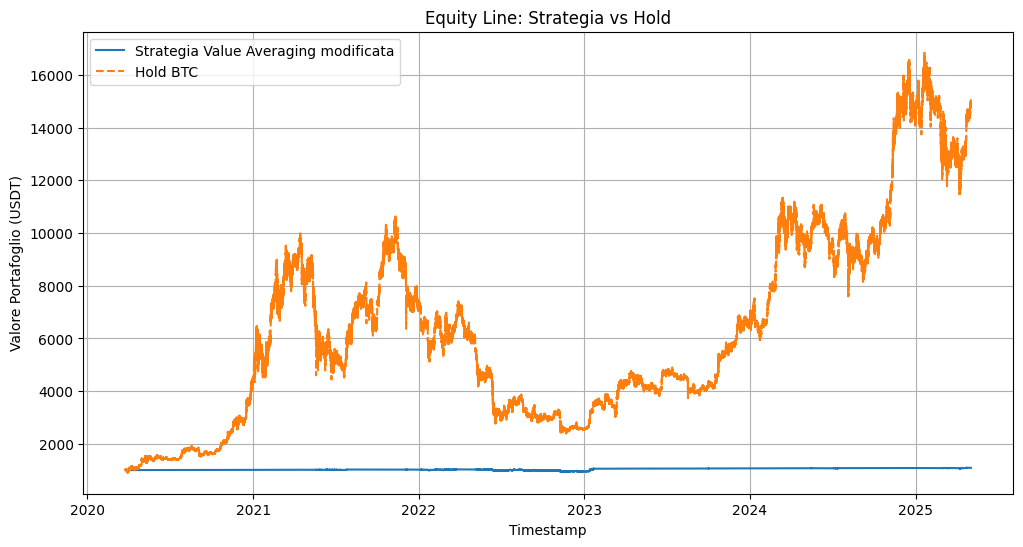

In [30]:
# Grafico
plot_equity_with_hold(transactions, btc_ohlcv, initial_cash=1000.0)

In [31]:
transactions['azione'].value_counts()

azione
niente      2683367
acquisto       1430
vendita         168
Name: count, dtype: int64

In [32]:
transactions['portafoglio_totale'].max()

1087.1203069762169

### Ricerca dei migliori parametri

In [33]:
# def optimize_parameters(
#     btc_ohlcv: pd.DataFrame,
#     initial_cash: float,
#     max_evals: int = 100
# ) -> tuple[dict, pd.DataFrame]:
#     """
#     Trova i migliori parametri per la strategia simulate_value_averaging_modified
#     massimizzando il rapporto tra valore finale e valore iniziale del portafoglio.

#     Parametri di ottimizzazione:
#     - timeframe: frequenza di valutazione (minuti), intero continuo tra 1 e len(btc_ohlcv)
#     - aumento_obiettivo: incremento dell'obiettivo (assoluto o percentuale)
#     - tp: take profit (0.0-0.2)
#     - compra_pure: True/False
#     - acquisto_classico: True/False

#     Nota: aumento_obiettivo è condizionato da obiettivo_percentuale:
#     - se obiettivo_percentuale=False: aumento_obiettivo in [0.001, 1000]
#     - se obiettivo_percentuale=True: aumento_obiettivo in [0.001, 1]

#     Ritorna:
#     - best_params: dizionario dei parametri ottimizzati
#     - best_result: DataFrame dei risultati con i parametri ottimi
#     """

#     def objective(params):
#         # Casting dei parametri
#         timeframe = int(params['timeframe'])
#         aumento_obj = params['aumento_obiettivo']
#         # Esegue la simulazione
#         result = simulate_value_averaging_modified(
#             btc_ohlcv=btc_ohlcv,
#             timeframe=timeframe,
#             aumento_obiettivo=aumento_obj,
#             tp=params['tp'],
#             compra_pure=params['compra_pure'],
#             initial_cash=initial_cash,
#             obiettivo_percentuale=params['obiettivo_percentuale'],
#             acquisto_classico=params['acquisto_classico']
#         )
#         final_value = result['portafoglio_totale'].iloc[-1]
#         return {'loss': - final_value / initial_cash, 'status': STATUS_OK}

#     # Range per il timeframe basato sulla lunghezza dei dati
#     max_tf = len(btc_ohlcv)
#     common_space = {
#         'timeframe': hp.quniform('timeframe', 1, max_tf, 1),
#         'tp': hp.uniform('tp', 0.0, 0.2),
#         'compra_pure': hp.choice('compra_pure', [True, False]),
#         'acquisto_classico': hp.choice('acquisto_classico', [True, False])
#     }
#     space_non_pct = {
#         **common_space,
#         'obiettivo_percentuale': False,
#         'aumento_obiettivo': hp.uniform('aumento_abs', 0.001, 1000)
#     }
#     space_pct = {
#         **common_space,
#         'obiettivo_percentuale': True,
#         'aumento_obiettivo': hp.uniform('aumento_pct', 0.001, 1)
#     }
#     space = hp.choice('ob_mode', [space_non_pct, space_pct])

#     trials = Trials()
#     best = fmin(
#         fn=objective,
#         space=space,
#         algo=tpe.suggest,
#         max_evals=max_evals,
#         trials=trials
#     )

#     # Ricostruzione dei parametri ottimali
#     ob_mode = best['ob_mode']
#     best_params = {
#         'timeframe': int(best['timeframe']),
#         'tp': best['tp'],
#         'compra_pure': [True, False][best['compra_pure']],
#         'acquisto_classico': [True, False][best['acquisto_classico']],
#         'obiettivo_percentuale': bool(ob_mode)
#     }
#     # Aggiungiamo aumento_obiettivo dal corretto sottospazio
#     if ob_mode == 0:
#         best_params['aumento_obiettivo'] = best['aumento_abs']
#     else:
#         best_params['aumento_obiettivo'] = best['aumento_pct']

#     # Simulazione finale
#     best_result = simulate_value_averaging_modified(
#         btc_ohlcv=btc_ohlcv,
#         initial_cash=initial_cash,
#         **best_params
#     )

#     final_ratio = best_result['portafoglio_totale'].iloc[-1] / initial_cash
#     print(f"Rapporto finale/iniziale: {final_ratio:.4f}")

#     return best_params, best_result

In [34]:
def optimize_parameters(
    btc_ohlcv: pd.DataFrame,
    initial_cash: float,
    max_evals: int = 100
) -> tuple[dict, pd.DataFrame]:
    """
    Trova i migliori parametri per la strategia simulate_value_averaging_modified
    massimizzando il rapporto tra valore finale e valore iniziale del portafoglio,
    validandoli attraverso periodi multipli (cross-validation time-series).

    Parametri di ottimizzazione:
    - timeframe: frequenza di valutazione (minuti), intero continuo tra 1 e len(btc_ohlcv)
    - aumento_obiettivo: incremento dell'obiettivo (assoluto o percentuale)
    - tp: take profit (0.0-0.2)
    - compra_pure: True/False
    - acquisto_classico: True/False

    Nota: aumento_obiettivo è condizionato da obiettivo_percentuale:
    - se obiettivo_percentuale=False: aumento_obiettivo in [0.001, 1000]
    - se obiettivo_percentuale=True: aumento_obiettivo in [0.001, 1]

    La funzione suddivide btc_ohlcv in periodi annuali (dal 2020 al 2025) e
    ottimizza i parametri massimizzando la performance media su ciascun anno.

    Ritorna:
    - best_params: dizionario dei parametri ottimizzati
    - best_result: DataFrame dei risultati con i parametri ottimi simulati su tutto il dataset
    """
    # Preparazione dei periodi di validazione (ogni anno)
    years = sorted(btc_ohlcv.index.year.unique())
    test_periods = [btc_ohlcv[btc_ohlcv.index.year == y] for y in years]
    test_periods = [df for df in test_periods if not df.empty]

    def objective(params):
        ratios = []
        for period_df in test_periods:
            tf = int(params['timeframe'])
            # Simulazione sul singolo periodo annuale
            result = simulate_value_averaging_modified(
                btc_ohlcv=period_df,
                timeframe=tf,
                aumento_obiettivo=params['aumento_obiettivo'],
                tp=params['tp'],
                compra_pure=params['compra_pure'],
                initial_cash=initial_cash,
                obiettivo_percentuale=params['obiettivo_percentuale'],
                acquisto_classico=params['acquisto_classico']
            )
            # Rapporto finale/iniziale per il periodo
            ratios.append(result['portafoglio_totale'].iloc[-1] / initial_cash)
        # Loss = - media delle performance (minimizzato da Hyperopt)
        loss = -np.mean(ratios)
        return {'loss': loss, 'status': STATUS_OK}

    # Definizione dello spazio di ricerca
    max_tf = len(btc_ohlcv)
    common_space = {
        'timeframe': hp.quniform('timeframe', 1, max_tf, 1),
        'tp': hp.uniform('tp', 0.0, 0.2),
        'compra_pure': hp.choice('compra_pure', [True, False]),
        'acquisto_classico': hp.choice('acquisto_classico', [True, False])
    }
    space_non_pct = {
        **common_space,
        'obiettivo_percentuale': False,
        'aumento_obiettivo': hp.uniform('aumento_abs', 0.001, 1000)
    }
    space_pct = {
        **common_space,
        'obiettivo_percentuale': True,
        'aumento_obiettivo': hp.uniform('aumento_pct', 0.001, 1)
    }
    space = hp.choice('ob_mode', [space_non_pct, space_pct])

    # Esecuzione dell'ottimizzazione
    trials = Trials()
    best = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=max_evals,
        trials=trials
    )

    # Ricostruzione dei parametri ottimali
    ob_mode = best['ob_mode']
    best_params = {
        'timeframe': int(best['timeframe']),
        'tp': best['tp'],
        'compra_pure': [True, False][best['compra_pure']],
        'acquisto_classico': [True, False][best['acquisto_classico']],
        'obiettivo_percentuale': bool(ob_mode)
    }
    if ob_mode == 0:
        best_params['aumento_obiettivo'] = best['aumento_abs']
    else:
        best_params['aumento_obiettivo'] = best['aumento_pct']

    # Simulazione finale sull'intero dataset
    best_result = simulate_value_averaging_modified(
        btc_ohlcv=btc_ohlcv,
        initial_cash=initial_cash,
        **best_params
    )

    final_ratio = best_result['portafoglio_totale'].iloc[-1] / initial_cash
    print(f"Rapporto finale/iniziale su tutto il periodo: {final_ratio:.4f}")

    return best_params, best_result

In [36]:
best_params, best_transactions = optimize_parameters(btc_ohlcv=btc_ohlcv, initial_cash=1000.0, max_evals=100)
best_params

100%|██████████| 100/100 [7:21:30<00:00, 264.91s/trial, best loss: -2.003694955494051]  
Rapporto finale/iniziale su tutto il periodo: 13.5420


{'timeframe': 3162,
 'tp': 0.09291923436902311,
 'compra_pure': True,
 'acquisto_classico': True,
 'obiettivo_percentuale': True,
 'aumento_obiettivo': 0.9303153128659275}

In [37]:
best_transactions

,prezzo,azione,valore_bitcoin,liquidità,portafoglio_totale
timestamp,,,,,
2020-03-25 10:36:00,6500.0,niente,0.000000,1000.0,1000.000000
2020-03-25 10:37:00,6500.0,niente,0.000000,1000.0,1000.000000
2020-03-25 10:38:00,6500.0,niente,0.000000,1000.0,1000.000000
2020-03-25 10:39:00,6500.0,niente,0.000000,1000.0,1000.000000
2020-03-25 10:40:00,6500.0,niente,0.000000,1000.0,1000.000000
...,...,...,...,...,...
2025-05-02 23:56:00,96796.9,niente,13535.227071,0.0,13535.227071
2025-05-02 23:57:00,96831.7,niente,13540.093197,0.0,13540.093197
2025-05-02 23:58:00,96833.5,niente,13540.344894,0.0,13540.344894


In [38]:
mdp.calcola_principali_metriche(best_transactions['portafoglio_totale'], best_transactions['prezzo'], best_transactions['valore_bitcoin'] / best_transactions['prezzo'])

{'Total Return %': 1254.1980918607878,
 'Max Drawdown %': 77.58593241189666,
 'Volatility': 0.014047481076553467,
 'Sharpe Ratio': 0.024434812393292822,
 'Sortino Ratio': 0.03778993102728508,
 'Calmar Ratio': 16.16527704020317,
 'Profit Factor': 299557704865.9321,
 'PnL': 0.1839109641915074}

c:\Users\Alessandro\Desktop\Cartelle\Mie\Programmi personali in Python\Giochi e simulazioni\Simulazioni\Simulatore di compravendita\Analisi Bitcoin\myenv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


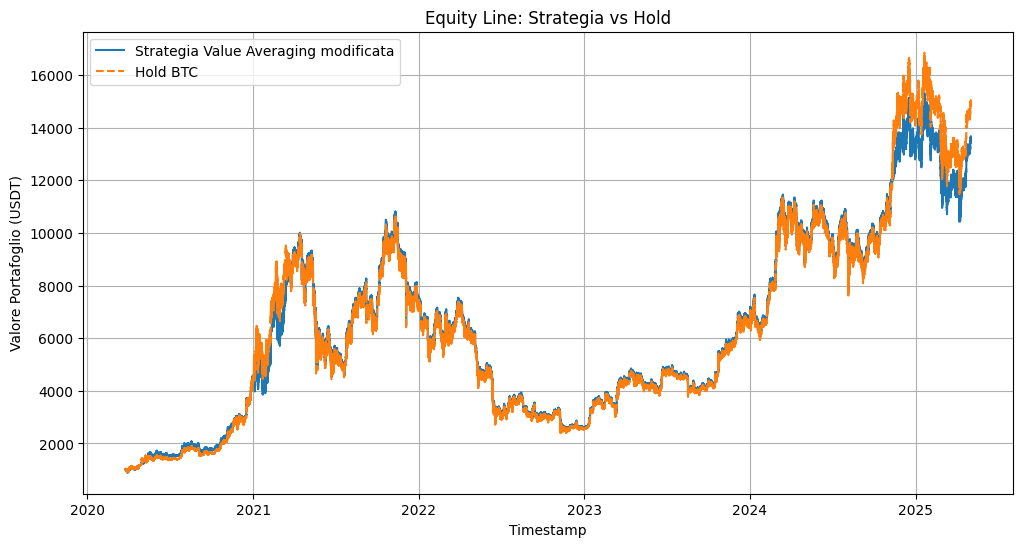

In [39]:
plot_equity_with_hold(best_transactions, btc_ohlcv, initial_cash=1000.0)

In [40]:
best_transactions['azione'].value_counts()

azione
niente                       2684116
niente (tentato acquisto)        788
acquisto                          41
vendita                           20
Name: count, dtype: int64